Running Newcomb's Problem...
Running Parfit's Hitchhiker...


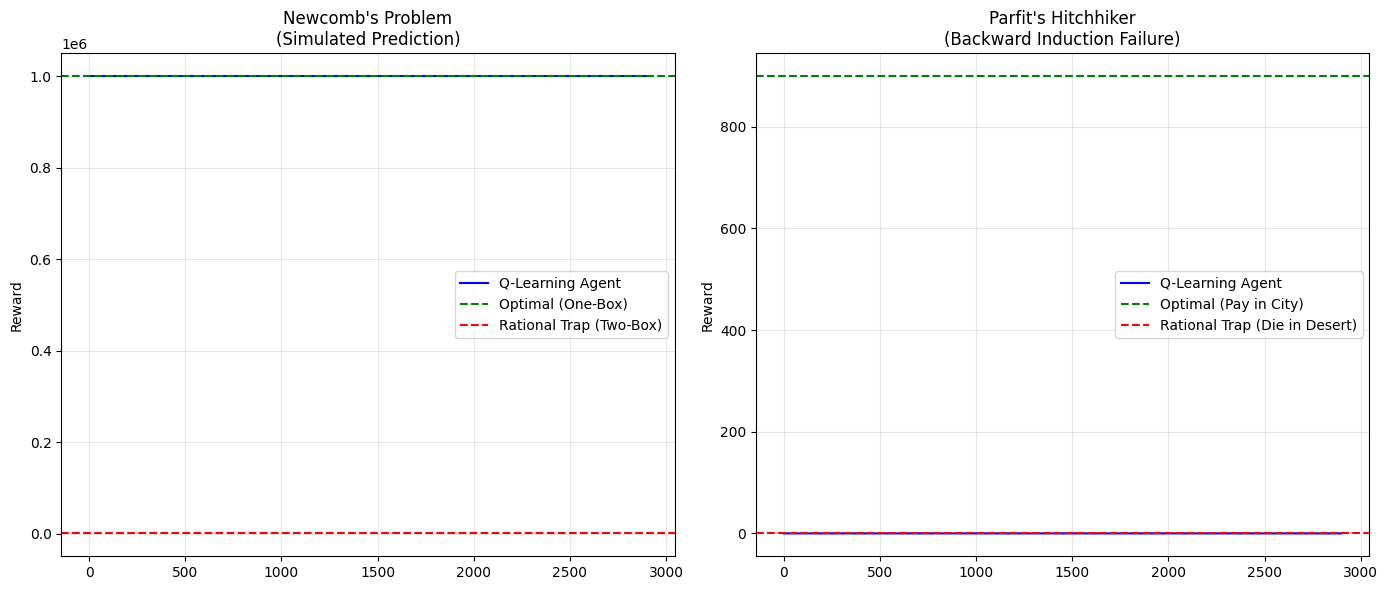

In [1]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt

# =====================================================================
# 1. THE AGENT (The "Source Code" to be copied)
# =====================================================================
class QLearningAgent:
    def __init__(self, num_states, num_actions, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.Q = np.zeros((num_states, num_actions))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.num_actions = num_actions

    def predict_action(self, state):
        """
        THE OMEGA INTERFACE:
        This allows the environment to 'simulate' the agent deterministically.
        It returns what the agent believes is the optimal move in a given state.
        This is equivalent to reading the agent's 'source code'.
        """
        # Returns the greedy action (no exploration noise)
        return np.argmax(self.Q[state])

    def act(self, state):
        """
        THE PHYSICAL ACTION:
        Includes exploration noise (epsilon-greedy).
        """
        if np.random.random() < self.epsilon:
            return np.random.randint(self.num_actions)
        return self.predict_action(state)

    def update(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.Q[next_state])
        td_target = reward + self.gamma * self.Q[next_state][best_next_action]
        self.Q[state][action] += self.alpha * (td_target - self.Q[state][action])


# =====================================================================
# 2. NEWCOMB'S PROBLEM (Deterministic Simulation)
# =====================================================================
class NewcombsProblemEnv(gym.Env):
    """
    State 0: The Choice Room
    Actions: 0 (One-Box), 1 (Two-Box)
    """
    def __init__(self):
        super().__init__()
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Discrete(1)

    def reset(self):
        return 0, {}

    def step(self, action, agent_oracle):
        # 1. THE PREDICTION (Acausal Step)
        # Omega simulates the agent in the starting state (0)
        predicted_action = agent_oracle.predict_action(state=0)
        
        # Omega fills Box B based on the simulation
        # If agent would One-Box, put 1,000,000. Else 0.
        box_b_content = 1000000 if predicted_action == 0 else 0
        box_a_content = 1000 # Transparent box
        
        # 2. THE PHYSICAL PAYOFF (Causal Step)
        if action == 0: # One-Box
            reward = box_b_content
        else:           # Two-Box
            reward = box_b_content + box_a_content
            
        return 0, reward, True, False, {"predicted": predicted_action}


# =====================================================================
# 3. PARFIT'S HITCHHIKER (Simultaneous / Sequential)
# =====================================================================
class ParfitsHitchhikerEnv(gym.Env):
    """
    State 0: The Desert
    State 1: The City
    Actions: 0 (Don't Pay), 1 (Pay)
    """
    def __init__(self):
        super().__init__()
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Discrete(2)
        self.state = 0

    def reset(self):
        self.state = 0
        return 0, {}

    def step(self, action, agent_oracle):
        
        # --- STATE 0: THE DESERT (The Prediction) ---
        if self.state == 0:
            # Omega simulates: "What would this agent do if they reached the City (State 1)?"
            predicted_city_action = agent_oracle.predict_action(state=1)
            
            if predicted_city_action == 1: # Agent would Pay
                # Ride accepted!
                self.state = 1
                return 1, 1000, False, False, {"msg": "Ride accepted"}
            else: # Agent would NOT Pay
                # Driver leaves you to die
                return 0, 0, True, False, {"msg": "Left in desert"}

        # --- STATE 1: THE CITY (The Payment) ---
        elif self.state == 1:
            if action == 1: # Pay
                return 1, -100, True, False, {"msg": "Paid debt"}
            else: # Don't Pay
                return 1, 0, True, False, {"msg": "Stiffed driver"}


# =====================================================================
# 4. RUNNER & PLOTTING
# =====================================================================
def run_simulation(env_class, name, steps=3000):
    env = env_class()
    # Hitchhiker needs 2 states, Newcomb needs 1. We allocate 2 to be safe.
    agent = QLearningAgent(num_states=2, num_actions=2, epsilon=0.05)
    
    rewards = []
    
    for _ in range(steps):
        state, _ = env.reset()
        done = False
        total_reward = 0
        
        while not done:
            # 1. Agent chooses action
            action = agent.act(state)
            
            # 2. Environment steps (Passing the agent itself for simulation!)
            next_state, reward, done, _, info = env.step(action, agent)
            
            # 3. Agent learns
            agent.update(state, action, reward, next_state)
            
            state = next_state
            total_reward += reward
            
        rewards.append(total_reward)

    return rewards

if __name__ == "__main__":
    # Setup plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # --- Run Newcomb ---
    print("Running Newcomb's Problem...")
    newcomb_rewards = run_simulation(NewcombsProblemEnv, "Newcomb")
    
    # Moving average
    window = 100
    avg_newcomb = np.convolve(newcomb_rewards, np.ones(window)/window, mode='valid')
    
    ax1.plot(avg_newcomb, label="Q-Learning Agent", color='blue')
    ax1.axhline(y=1000000, color='green', linestyle='--', label="Optimal (One-Box)")
    ax1.axhline(y=1000, color='red', linestyle='--', label="Rational Trap (Two-Box)")
    ax1.set_title("Newcomb's Problem\n(Simulated Prediction)")
    ax1.set_ylabel("Reward")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # --- Run Hitchhiker ---
    print("Running Parfit's Hitchhiker...")
    hitchhiker_rewards = run_simulation(ParfitsHitchhikerEnv, "Hitchhiker")
    
    avg_hitch = np.convolve(hitchhiker_rewards, np.ones(window)/window, mode='valid')
    
    ax2.plot(avg_hitch, label="Q-Learning Agent", color='blue')
    ax2.axhline(y=900, color='green', linestyle='--', label="Optimal (Pay in City)")
    ax2.axhline(y=0, color='red', linestyle='--', label="Rational Trap (Die in Desert)")
    ax2.set_title("Parfit's Hitchhiker\n(Backward Induction Failure)")
    ax2.set_ylabel("Reward")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()